# GRU Model for Stock Price Prediction

This file contains a detailed implementation of a GRU (Gated Recurrent Unit) model aimed at predicting stock prices based on historical price data. The GRU architecture is particularly suited for time series forecasting due to its ability to capture temporal dependencies effectively, simplifying the learning process compared to more complex models like LSTMs while still maintaining a high level of performance.

## Model Architecture

The GRU model implemented in PyTorch includes several core components designed to optimize stock price prediction:

- **GRU Layers**: The model utilizes one or more GRU layers to process time series data sequentially, maintaining hidden states that carry information across time steps.
- **Input Layer**: Accepts sequences of historical stock prices, transforming each sequence into a format suitable for time series forecasting.
- **Output Layer**: A linear layer that maps the output of the GRU to a predicted future stock price.
- **Loss Function and Optimizer**: The model uses Mean Squared Error (MSE) as its loss function to measure the accuracy of predictions and an Adam optimizer to adjust model weights based on the computed gradients.

## Forecasting Process

Forecasting with the GRU model involves several critical steps to ensure accurate predictions:

1. **Data Preparation**: Historical stock data is first scaled using MinMax scaling to aid in neural network training. The data is then segmented into input sequences that serve as training examples for the model.

2. **Model Initialization**: Parameters such as learning rate, number of GRU layers, and the size of each layer are set to initialize the model configuration.

3. **Training Loop**: The model trains across multiple epochs, processing the input data, calculating the loss at each step, and updating the weights to reduce prediction errors continuously.

4. **Evaluation**: After training, the model’s performance is evaluated on a separate testing dataset to verify its predictive accuracy in real-world conditions.

5. **Visualization**: The training and testing results, including the predicted and actual stock prices, are visualized using Plotly for a clear, interactive comparison of the model's performance.

## Multiple Simulations

The robustness of the GRU model is tested through multiple simulations, where the model is trained and evaluated repeatedly with potentially varying initial conditions to assess the consistency of its predictions:

1. **Repeatability**: Each simulation runs the model from scratch, ensuring that the learning process starts anew, providing insights into the stability and reliability of the model under different initializations.

2. **Performance Analysis**: Variations in performance across simulations help identify the model's strengths and limitations, guiding further tweaks and optimizations.

## Usage Instructions

To utilize the GRU model for stock price forecasting, follow these steps:

1. **Load Data**: Import your dataset containing historical stock price information.
2. **Set Model Parameters**: Adjust the model settings, including the learning rate, number of hidden layers, and neurons per layer based on your specific requirements.
3. **Prepare Data**: Normalize the dataset and organize it into training and testing sequences.
4. **Instantiate and Train Model**: Create an instance of the GRU model and run the training process using the prepared data.
5. **Evaluate and Visualize**: After training, evaluate the model on the test data and use visualization tools to compare the predicted results against actual historical prices.

## Requirements

- Python 3.x
- PyTorch
- NumPy
- Plotly

This GRU model provides a powerful yet straightforward approach for financial analysts and data scientists to forecast stock prices effectively. By leveraging temporal patterns in historical data, the model aids in making informed predictions that can be crucial for investment and trading strategies.

In [7]:
# !pip install yfinance tensorflow keras numpy matplotlib seaborn tqdm scikit-learn graphviz

In [1]:
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import plotly.graph_objects as go


# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [16]:
# stock configs
ticker = ['TSLA']
start_date = '2014-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

In [17]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(2520, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-04-01,13.934667,14.544000,13.905333,14.464667,110571000,0.0,0.0
1,2014-04-02,14.666667,15.392667,14.536667,15.352667,161734500,0.0,0.0
2,2014-04-03,15.353333,15.715333,14.800000,15.026667,163855500,0.0,0.0
3,2014-04-04,15.067333,15.218000,14.083333,14.148667,170184000,0.0,0.0
4,2014-04-07,13.720667,14.413333,13.567333,13.834667,147832500,0.0,0.0


# Model Implementation

Below we implement the model, first we separate the data into a train-test split.  For this LSTM model, we will leverage continuous windows of time for training and test data.


In [52]:
scaler = MinMaxScaler()
minmax = scaler.fit(data.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(data.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.012205
1,0.014423
2,0.013608
3,0.011415
4,0.010631


In [53]:
simulation_size = 5
lookback = 30
train_len = int(included_days * train_size)
test_len = included_days - train_len

df_train = df_log.iloc[:train_len]
df_test = df_log.iloc[train_len:]


def create_dataset(X, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X)-look_back):
        a = X[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(X[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

lookback = 30  # this variable was previously defined but not used in your example
X_train, y_train = create_dataset(df_train.values, lookback)
X_test, y_test = create_dataset(df_test.values, lookback)

# Adjust for LSTM input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [20]:
class Model(nn.Module):
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias=0.1):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.size_layer = size_layer
        self.output_size = output_size
        self.dropout = forget_bias
        
        # Define the GRU layers
        self.gru = nn.GRU(size, size_layer, num_layers, batch_first=True, dropout=1-forget_bias)
        self.linear = nn.Linear(size_layer, output_size)
        
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, hidden):
        x, h = self.gru(x, hidden)
        x = self.linear(x[:, -1])  # Taking the output corresponding to the last timestep
        return x, h

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(self.num_layers, batch_size, self.size_layer)

def calculate_accuracy(real, predict):
    real = torch.tensor(real) + 1
    predict = torch.tensor(predict) + 1
    percentage = 1 - torch.sqrt(torch.mean(torch.pow((real - predict) / real)))
    return percentage.item() * 100

In [21]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [22]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 20
dropout_rate = 0.8
future_day = 60
learning_rate = 0.01

In [47]:
def forecast(model, X_train, y_train, X_test, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # Assuming X_train is correctly shaped [batch_size, seq_length, num_features]
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)

    for epoch in range(epochs):
        model.optimizer.zero_grad()
        # Here, ensure batch_size is correctly reflected
        hidden = model.init_hidden(X_train_tensor.size(0)).to(device)
        outputs, _ = model(X_train_tensor, hidden)
        loss = model.loss_fn(outputs, y_train_tensor)
        loss.backward()
        model.optimizer.step()
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss {loss.item()}')

    # Evaluation
    model.eval()
    # Ensure X_test is shaped and batched correctly
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    hidden = model.init_hidden(X_test_tensor.size(0)).to(device)
    with torch.no_grad():
        test_pred, _ = model(X_test_tensor, hidden)
    
    return test_pred.squeeze().cpu().numpy()


In [87]:
def run_model_iterations(n_iterations, X_train, y_train, X_test):
    predictions = []
    for _ in range(n_iterations):
        # Initialize the model
        model = Model(learning_rate=0.01, num_layers=1, size=1, size_layer=128, output_size=1, forget_bias=0.1)
        
        # Train and predict
        preds = forecast(model, X_train, y_train, X_test)
        arr = scaler.inverse_transform(preds.reshape(-1, 1)).tolist()
        arr = [p[0] if isinstance(p, list) else p for p in arr]
        predictions.append(arr)
    
    return predictions

In [88]:
# Run the model multiple times
n_iterations = 5
start_date = "2021-01-01"
model_predictions = run_model_iterations(n_iterations, X_train, y_train, X_test)
actual_data = y_test.flatten()
dates = pd.date_range(start=start_date, periods=len(y_test), freq='D')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1



Epoch 0 Loss 0.08344364911317825
Epoch 5 Loss 0.018050245940685272
Epoch 10 Loss 0.010144520550966263
Epoch 15 Loss 0.0045931171625852585


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1



Epoch 0 Loss 0.12016374617815018
Epoch 5 Loss 0.0029188026674091816
Epoch 10 Loss 0.009843308478593826
Epoch 15 Loss 0.0042527285404503345


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1



Epoch 0 Loss 0.08013785630464554
Epoch 5 Loss 0.00950758159160614
Epoch 10 Loss 0.0024556333664804697
Epoch 15 Loss 0.0017105257138609886


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1



Epoch 0 Loss 0.08744994550943375
Epoch 5 Loss 0.01440255343914032
Epoch 10 Loss 0.0018275909824296832
Epoch 15 Loss 0.0026444834657013416


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1



Epoch 0 Loss 0.1289994716644287
Epoch 5 Loss 0.00222326279617846
Epoch 10 Loss 0.026722652837634087
Epoch 15 Loss 0.021040352061390877


In [89]:

print(model_predictions[0])


[232.7776336669922, 228.005859375, 231.50608825683594, 224.5502471923828, 219.8852081298828, 209.67495727539062, 206.43551635742188, 197.1146697998047, 197.73126220703125, 208.8198699951172, 224.91323852539062, 232.32057189941406, 231.0323028564453, 236.42300415039062, 225.87705993652344, 221.08055114746094, 220.47702026367188, 222.192626953125, 221.84228515625, 217.13302612304688, 205.1278839111328, 201.92625427246094, 208.68080139160156, 201.31333923339844, 198.06260681152344, 209.23435974121094, 215.4995880126953, 216.61630249023438, 222.88143920898438, 226.07559204101562, 219.72743225097656, 213.38177490234375, 208.52188110351562, 208.01739501953125, 211.57269287109375, 212.84716796875, 220.4482879638672, 228.4102325439453, 222.27418518066406, 217.0736541748047, 217.59901428222656, 219.12232971191406, 220.68408203125, 221.7065887451172, 225.0354766845703, 227.9687957763672, 243.20928955078125, 251.864990234375, 252.20249938964844, 245.94281005859375, 252.02310180664062, 259.8275756

In [90]:
# Dates for the X-axis (assuming you have a 'Date' column in your original data)
dates = pd.date_range(start=end_date, periods=len(y_test), freq='D')  # Adjust accordingly

# Creating traces for the actual and predicted stock prices
trace_actual = go.Scatter(
    x=dates,
    y=data['Close'].iloc[train_len:].values,
    mode='lines',
    name='Actual Price',
    line=dict(color='blue', width=2)
)

traces_predicted = []
for i, preds in enumerate(model_predictions):
    trace_predicted = go.Scatter(
        x=dates,
        y=preds,
        mode='lines',
        name=f'Predicted Price (Iteration {i+1})',
        line=dict(color=f'rgba(255, 0, 0, {1 - i*0.12})', dash='dot', width=2)  # Adjust opacity for clarity
    )
    traces_predicted.append(trace_predicted)

# Create the layout and figure
layout = go.Layout(
    title='Stock Price Prediction (Multiple Iterations)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    template='plotly_dark'
)

fig = go.Figure(data=[trace_actual] + traces_predicted, layout=layout)
fig.show()

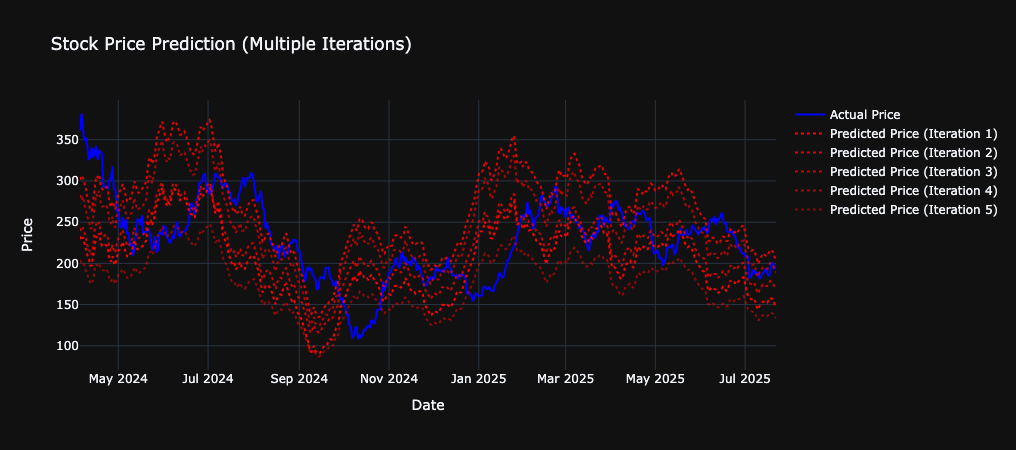